In [10]:
from jax import random
from jax import numpy as jnp
from jax import vmap
import numpy as onp
from jax.random import PRNGKey, split, uniform
import jax
from flax import struct
from typing import Union
from matplotlib import pyplot as plt
from functools import reduce

In [11]:
from itertools import permutations, product
list(product([0,3],permutations([1,2],2)))

[(0, (1, 2)), (0, (2, 1)), (3, (1, 2)), (3, (2, 1))]

In [12]:
Quaternion = jnp.ndarray
Vector3 = jnp.ndarray
BoxFace = jnp.ndarray
Point = jnp.ndarray

def rot_axis_to_quaternion(axis: Vector3, angle: jnp.ndarray) -> Quaternion:
    img = axis * jnp.sin(angle/2)
    real = jax.lax.cos(angle/2)[None]
    return jax.lax.concatenate([real, img], dimension=0)

def rotate(vec: Vector3, quat: Quaternion):
  """Rotates a vector vec by a unit quaternion quat.

  Args:
    vec: (3,) a vector
    quat: (4,) a quaternion

  Returns:
    ndarray(3) containing vec rotated by quat.
  """
  if len(vec.shape) != 1:
    raise AssertionError('vec must have no batch dimensions.')
  s, u = quat[0], quat[1:]
  r = 2 * (jnp.dot(u, vec) * u) + (s * s - jnp.dot(u, u)) * vec
  r = r + 2 * s * jnp.cross(u, vec)
  return r

q = rot_axis_to_quaternion(jnp.array([0.,1.,0.]), jnp.array(jnp.pi/4))
vec = jnp.array([1.0,2.0,1.0])
rotate(vec, q)

DeviceArray([1.4142137, 2.0000002, 0.       ], dtype=float32)

In [13]:
Quaternion = jnp.ndarray

def sample_quaternion(rng: PRNGKey):
    # sample imaginary part of quaternion (axis of rotation)
    key, *subkeys = split(rng, 4)
    axis = (
        uniform(subkeys[0], minval=-1.0, maxval=1.0, shape=(3,)) + 1e-6
    )
    axis = axis / jnp.linalg.norm(axis)

    # sample angle (how much to rotate)
    angle = (
        uniform(subkeys[1], minval=-2 * jnp.pi, maxval=2 * jnp.pi)
    )
    
    return rot_axis_to_quaternion(axis,angle)

In [14]:
Plane = jnp.ndarray
Box = jnp.ndarray

@jax.jit
def uniform_sample_plane(key)->Plane:
    '''samples a,b,c,d such that a+b+c = 1. A plane is characterized by equation ax + by + cz + d = 0
    '''
    eps = 1e-6
    keys = split(key, 3)
    a,b = jax.lax.sort(uniform(keys[0], shape=(2,)) * (1-eps) + eps) #avoids degenerate planes
    c = (1-b) + eps
    b = (b-a)
    d = uniform(keys[1])* 10 + eps
    return jnp.stack([a,b,c,d])


    
    
uniform_sample_plane(PRNGKey(0))

DeviceArray([4.6218246e-01, 1.6194582e-03, 5.3619909e-01, 7.1841822e+00],            dtype=float32)

In [15]:
v = jnp.arange(6).reshape(3,2)
v[0,1]

DeviceArray(1, dtype=int32)

In [16]:
((uniform(PRNGKey(0), shape=(1000,3))-0.5) * 2).mean(axis=0)

DeviceArray([ 0.00127279,  0.03190355, -0.04826628], dtype=float32)

In [17]:
def make_corners_from_half_vectors(v1, v2, v3):
    """make corners keeping v1 static and adding +-v2 and +-v3 to make a box. The last corner isn't necessary.
    """
    a = v2+v3
    b = v2-v3
    c = -v2-v3
    # TODO: how am I supposed to check if this works then?
    # assert jnp.all(jnp.abs(jnp.dot(a-b,c-b)) < 1e-4)
    return v1[None] + jnp.stack([a,b,c],axis=0)

def translate_plane(p: Plane, t:Vector3):
    assert p.shape==(4,)
    assert t.shape == (3,)
    d = p[-1] - (p[:3]*t).sum()[None]
    return jnp.concatenate([p[:3], d], axis=0)
    
                         
def sample_box(key):
    '''
    samples a box, which is a set of box_faces, each box face is a plane and a set of three points in such plane that delimit it.
    returns:
        Box:
            planes: (6,4) array with the 6 planes each belonging to a box_face, planes are parameterized such that ax + by + cz + d = 0
            corners: (6,3,3) array with 6 sets of 3 points (each of size 3) where each point is a corner delimiting the box_face. The second point is the corner.
    NOTE: the normal of the plane a,b,c is parameterized to look away from the origin. This can be used to check if a ray is hitting it from behind or
    from the front. I would assume front is 
    '''
    eps = 1e-6
    ks = split(key,3)
    
    #half sizes
    hx,hy,hz = uniform(ks[0], shape=(3,)) + eps
    # hx,hy,hz = 1,1,1
    
    #traslation
    t = (uniform(ks[2], shape=(3,)) - 0.5) * 3 + eps #TODO: I need to calibrate this so that I always sample on the field of vision.
    # t = t - jnp.array([0,0,4])
    # t = jnp.array([0,0,0])
    
    #rotation
    q = sample_quaternion(ks[1])
    # q = rot_axis_to_quaternion(jnp.array([0,1,0]),angle=jnp.pi/4)
    
    planes_d = jnp.stack([hx,hy,hz]).reshape(-1,1)
    hs = jnp.eye(3) * planes_d
    
    v_rotate = vmap(rotate, in_axes=(0,None))
    
    hs = v_rotate(hs,q)
    
    corners = []
    for i in range(3):
        k,j = {0,1,2}.difference({i})
        pos = make_corners_from_half_vectors(-hs[i], hs[k], hs[j])
        neg = make_corners_from_half_vectors(hs[i], hs[k], hs[j])
        corners.append([pos,neg])

    corners = jnp.array(corners)
    
    planes_d = jnp.concatenate([planes_d,planes_d],axis=0)
    
    normals = jnp.concatenate([jnp.eye(3), -jnp.eye(3)], axis=0)
    normals = v_rotate(normals, q)
    
    box_planes = jnp.concatenate([normals, planes_d], axis=1)
    box_planes = vmap(translate_plane, in_axes=(0,None))(box_planes, t)
    
    faces_corners = jnp.concatenate([corners[:,0],corners[:,1]])+t

    return dict(faces_planes= box_planes, faces_corners=faces_corners)

box = sample_box(PRNGKey(i))
for i in range(10):
    box = sample_box(PRNGKey(i))
    x,y,z = box['faces_corners'][0,0]
    d = get_depth_pixel_from_plane(x,y, box['faces_planes'][0])
    assert jnp.allclose(d, z, atol=2e-2), (d,z,i, box)
box['faces_corners'][0,0], box['faces_planes'][0],get_depth_pixel_from_plane(1.4142,1.0, box['faces_planes'][0])
box

NameError: name 'i' is not defined

In [18]:
def point_in_box_face(d: Point, b:BoxFace):
    """
    Args:
        - p: (d,) shaped array including coordinates of point
        - b: (3,d) shaped array including 3 points determining the box face, the second (b[1]) must be the corner uniting the other points.
    returns:
        - true if the point is inside the boxface, i.e the projection of the point to each edge is less than the size of the edge.
        
    NOTE: this doesn't check it but d should be guaranteed to be on the plane of BoxFace or this would just not work.
    """
    assert d.shape == (3,) and b.shape==(3,3)
    e1 = b[0] - b[1]
    e2 = b[2] - b[1]
    p = d - b[1]

    
    pr1 = jnp.dot(p,e1)/(jnp.linalg.norm(e1))**2
    pr2 = jnp.dot(p,e2)/(jnp.linalg.norm(e2))**2
    # print(p,e1,e2,pr1,pr2)
    def proj_within(pr):
        return (pr >= 0) & (pr <= 1)
    
    return proj_within(pr1) & proj_within(pr2)

point_in_box_face(jnp.array([1.,0,-1]), box['faces_corners'][0]), box['faces_corners'][0]

(DeviceArray(False, dtype=bool),
 DeviceArray([[ 0.16053993, -0.40080154,  1.7752507 ],
              [ 0.10749245, -0.34280074,  1.7582191 ],
              [ 0.51577246, -0.51610607, -0.10361707]], dtype=float32))

In [19]:
def get_depth_pixel_from_plane(x,y,p:Plane):
    """does orthographic projection of a pixel and returns the z value, we assume right handed coordinates where z is coming into the camera
    the camera is assumed to be at the origin. This function doesn't work with degenerate planes. If the plane is not in "front" of the camera (i.e. the z value
    is less than 0) then it returs 0
    """
    #TODO should I ignore points that are looking "away"? i.e. taking into account the orientation of the normal?.
    v = (-p[3] - p[0] * x - p[1]*y)/p[2]
    # v = jax.lax.cond(v>0, lambda: 0.0, lambda: v)
    return v
    # return jnp.array([x,y,(-p.d - p.a * x - p.b*y)/p.c])

def get_depth_pixel_from_box_face(x,y, face_plane, face_corners):
    z = get_depth_pixel_from_plane(x,y, face_plane)
    plane_inter = jnp.array([x,y,z])
    return jax.lax.cond(point_in_box_face(plane_inter, face_corners), lambda: z, lambda: -2.0)

def get_depth_pixel_from_box(x,y, box):
    """takes a box dict with 'faces_planes' and 'faces_corners' and returns the depth of the closest intersection with all of the box's planes
    """
    all_depths = vmap(get_depth_pixel_from_box_face, in_axes=(None,None,0,0))(x,y, box['faces_planes'], box['faces_corners'])
    return all_depths.max()
    
render_face = vmap(vmap(get_depth_pixel_from_box_face,in_axes=(None,0,None,None)),in_axes=(0,None,None,None))
render_box = vmap(vmap(get_depth_pixel_from_box, in_axes=(None,0,None)), in_axes=(0,None,None))

"""vectorizes over vectors xs and ys to compute the depth in the product of both vectors.
"""
render_depth_map = jax.vmap(jax.vmap(get_depth_pixel_from_plane, in_axes=(None,0,None)), in_axes=(0,None,None))

In [20]:
def score_point_box_face(point, face_plane, face_corners):
    x,y,z = point
    z_int = get_depth_pixel_from_plane(x,y, face_plane)
    plane_inter = jnp.array([x,y,z_int])
    z_int = jax.lax.cond(point_in_box_face(plane_inter, face_corners), lambda: z_int, lambda: -10.0)
    lpdf = jax.scipy.stats.norm.logpdf(z, loc=z_int)
    return lpdf
    
def score_point_from_box(point, box):
    all_scores = vmap(score_point_box_face, in_axes=(None,0,0))(point,box['faces_planes'], box['faces_corners'])
    return jax.scipy.special.logsumexp(all_scores)

def score_point_cloud_from_box(pc, box):
    all_scores = vmap(score_point_from_box, in_axes=(0,None))(pc, box)
    return all_scores.sum()

score_point_cloud_from_many_boxes = jax.jit(vmap(score_point_cloud_from_box, in_axes=(None, 0)))

In [23]:
def draw_box(box, res=300):
    xs= (jnp.arange(res)/res - 0.5)*6
    ys= (jnp.arange(res)/res - 0.5)*6
    depth_map = render_box(xs,ys,box)
    fig1, ax2 = plt.subplots(constrained_layout=True)

    cs = ax2.contourf(xs, ys, depth_map, 1000, cmap='hot')
    cbar = fig1.colorbar(cs)
    return ax2, fig1

def overimpose_point_cloud(fig, ax, pc):
    cs = ax.scatter(pc[:,1], pc[:,0], c=pc[:,2], s=2, cmap='hot')
    # fig.colorbar(cs)

In [ ]:
def concat_boxes(b1,b2):
    return dict(faces_corners=onp.concatenate([b1['faces_corners'],b2['faces_corners']]),
                faces_planes=onp.concatenate([b1['faces_planes'],b2['faces_planes']]))

-4914.544 0 -25.731884 1991791 1991791 1991791
(1205, 6, 3, 3)


array([ 0.03742581,  0.00055185, -0.03717769])

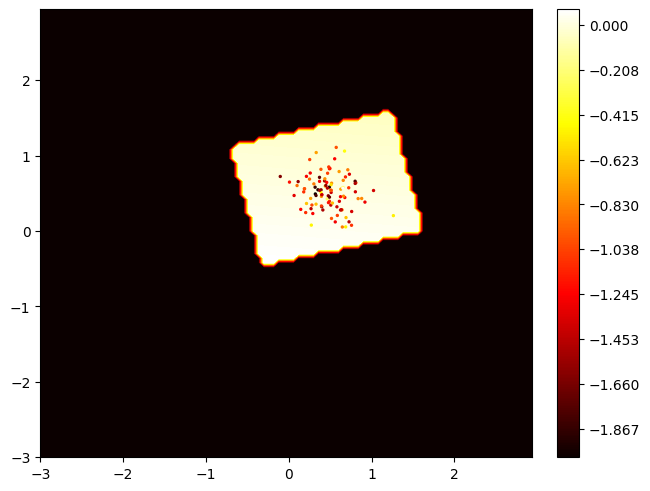

In [582]:
s = random.multivariate_normal(PRNGKey(1), jnp.zeros(3)+jnp.array([.5,.5,-.0]), cov=jnp.eye(3)/20, shape=(100,))


boxes = jax.jit(vmap(sample_box))(split(PRNGKey(i),500000))
all_scores = score_point_cloud_from_many_boxes(s, boxes)
# boxes = jax.tree_map(onp.array,boxes)
# all_scores = onp.array(all_scores)
# c_scores.append(all_scores)
# c_boxes.append(boxes)

# all_scores = onp.concatenate(c_scores)
# boxes = reduce(concat_boxes, c_boxes)
_, min_i, _ , max_i = all_scores.min(), all_scores.argmin(), all_scores.max(), all_scores.argmax()
print(all_scores.min(), all_scores.argmin(), all_scores.max(), all_scores.argmax(), max_i, int(max_i))
good_box = jax.tree_map(lambda x: x[all_scores>-40], boxes)
print(good_box['faces_corners'].shape)
ax,fig = draw_box(jax.tree_map(lambda x: x[max_i], boxes))
overimpose_point_cloud(fig, ax, s)
boxes['faces_corners'].sum(axis=0).sum(axis=0).sum(0)/(len(boxes['faces_corners'])*6*3)

In [321]:
%%time
boxes = jax.jit(vmap(sample_box))(split(PRNGKey(22),30000))

depth_maps = jax.jit(vmap(render_box, in_axes=(None,None,0)))(xs,ys,boxes)

CPU times: user 2.43 s, sys: 84.6 ms, total: 2.51 s
Wall time: 664 ms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((100, 3),
 (10,),
 {'faces_planes': DeviceArray([[-0.6285432 , -0.63900846, -0.44339776,  0.7642075 ],
               [-0.4610116 ,  0.76523435, -0.44931567,  0.56888735],
               [ 0.6264198 , -0.07800281, -0.7755732 ,  1.447316  ],
               [ 0.6285432 ,  0.63900846,  0.44339776, -0.13787696],
               [ 0.4610116 , -0.76523435,  0.44931567,  1.2586329 ],
               [-0.6264198 ,  0.07800281,  0.7755732 , -1.3047308 ]],            dtype=float32),
  'faces_corners': DeviceArray([[[-0.91721606,  1.5532568 ,  0.7852386 ],
                [-1.0065343 ,  1.564379  ,  0.89582396],
                [-0.16402644,  0.16589776,  1.7169574 ]],
  
               [[-0.4683839 , -0.24545479,  1.3286586 ],
                [-0.5577022 , -0.23433274,  1.4392439 ],
                [-0.16402644,  0.16589773,  1.7169574 ]],
  
               [[-1.4002101 ,  1.1641483 ,  0.6181104 ],
                [-0.5577022 , -0.23433268,  1.4392439 ],
                [-0.16402644,  0.16589773,

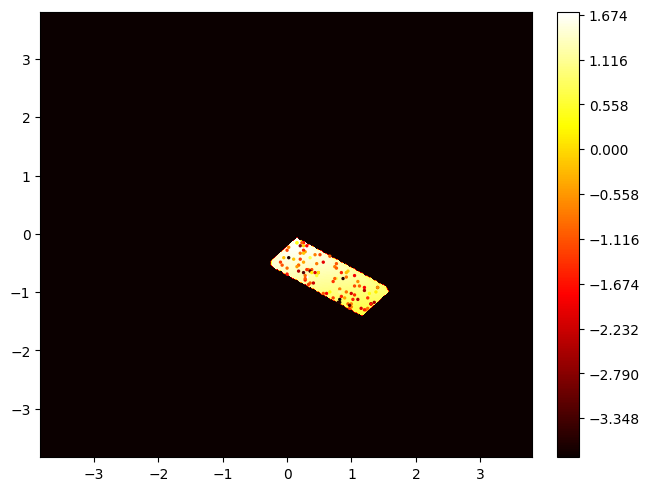

In [42]:
%load_ext autoreload
%autoreload 2
from box_model import generative_model, draw_box, overimpose_point_cloud
from jax.random import PRNGKey, split, choice
from jax import vmap
from jax import numpy as jnp

# pc, latents, box = vmap(generative_model, in_axes=(0,None,None,None))(PRNGKey(0), obs_p=0.7, obs_noise_std=0.8, num_points=100)
# pc, latents, box = vmap(generative_model, in_axes=(0,None,None,None))(split(PRNGKey(0)),0.7, 0.8, 100)

# for i in range(2):
#     generative_model(PRNGKey(i),obs_p=0.7, obs_noise_std=0.8, num_points=100)
pc, latents, box = generative_model(PRNGKey(0), obs_noise_std=0.8, num_points=100)
ax, fig = draw_box(box)
overimpose_point_cloud(fig, ax, pc)

# choice(PRNGKey(0),jnp.arange(5), shape=(10,))
pc.shape, latents.shape, box